In [14]:
from __future__ import unicode_literals, print_function, division
from numpy import *
import numpy as np

import pandas as pd
import datetime as dt
import csv
import torch
import pickle
from random import randint
import math

from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
PATH_TO_ORIGINAL_DATA = '/home/mamjad2/trivagodata/'
PATH_TO_PROCESSED_DATA = '/home/mamjad2/preprocessed_data'
train = pd.read_csv(PATH_TO_ORIGINAL_DATA + 'train.csv')
test = pd.read_csv(PATH_TO_ORIGINAL_DATA + 'test.csv')
item_meta = pd.read_csv(PATH_TO_ORIGINAL_DATA + 'item_metadata.csv')

In [16]:
#Subset data with refrence of item ID
dftrain=train[(train['action_type'] != 'change of sort order') & (train['action_type'] !='filter selection') & (train['action_type'] !='search for destination')& (train['action_type'] !='search for poi') & (train['reference']!='unknown')]

In [34]:
def item_session(df):
    datanp=[]
    counter=0
    for x in set(df['user_id']):
        #if(counter>100):
         #   break
        dfuser=df[df['user_id'] == x]
        for y in set(dfuser['session_id']):
            dfuser_session= dfuser[dfuser['session_id'] == y]
            dfuser_session=dfuser_session.sort_values('step')
            temp=dfuser_session['reference'].to_numpy() #Note:This sequence of interacted items can have repetetive item even consequetively! 
            if len(temp)>1: #At least length 2 sequence
                datanp.append([int(x) for x in temp])
                counter+=1

    listoflist= sorted(datanp, key=len, reverse=True)
    return listoflist

In [35]:
#testnpall=item_session(dftest1)
#pickle.dump(testnpall, open('testnpall.pkle', 'wb')) ##alredy dumped

In [36]:
#datanp = pickle.load(open('temp.pkle','rb'))
testnpall=pickle.load(open('testnpall.pkle','rb'))

In [57]:
n_items=0
item2idx={}
idx2item={}
#flat_list_train = unique([item for sublist in datanp for item in sublist])
flat_list_test = unique([item for sublist in testnpall for item in sublist])
# flat_list= (unique((flat_list_train.tolist()+flat_list_test.tolist()))).tolist()
for item in flat_list_test:
    item2idx[item]=n_items
    idx2item[n_items]=item
    n_items+=1

In [58]:
# n_items=0
# item2idx={}
# idx2item={}
# flat_list_train = unique([item for sublist in datanp for item in sublist])
# flat_list_test = unique([item for sublist in testnp for item in sublist])
# flat_list= (unique((flat_list_train.tolist()+flat_list_test.tolist()))).tolist()
# for item in flat_list_train:
#     item2idx[item]=n_items
#     idx2item[n_items]=item
#     n_items+=1
# n_items_train= n_items
# for item in flat_list_test:
#     if item not in flat_list_train:
#         item2idx[item]=n_items
#         idx2item[n_items]=item
#         n_items+=1
#     else:
#         continue

In [59]:
def seq2indx(seq):
    indx4seq=[]
    for item in seq:
        indx4seq.append(item2idx[item])
    return indx4seq

In [60]:
def tensor4seq(seq):
    indx4seq=[]
    for item in seq:
        indx4seq.append(item2idx[item])
    input_tensor = torch.tensor(indx4seq[:-1], dtype=torch.long).view(-1, 1) #remove the last
    output_tensor = torch.tensor(indx4seq[1:], dtype=torch.long).view(-1, 1) #remove the first
    tensor=torch.tensor(indx4seq, dtype=torch.long).view(-1, 1) #not removing anything
    return input_tensor, output_tensor, tensor

In [61]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [62]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, decoder, decoder_optimizer, criterion):
    decoder_hidden = decoder.initHidden()

    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    #encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        #print('ei', ei)
        decoder_output, decoder_hidden = decoder(input_tensor[ei], decoder_hidden)
        #print('input_tensor',input_tensor[ei])

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            loss += criterion(decoder_output, target_tensor[ei])
            decoder_input = target_tensor[ei].squeeze()  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[ei])
            #if decoder_input.item() == EOS_token:
               # break

    loss.backward()

    decoder_optimizer.step()

    return loss.item() / target_length

In [63]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [64]:
def trainIters(decoder, n_iters, print_every=5, plot_every=5, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensor4seq(testnpall[(randint(0, len(testnpall)-1))]) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, decoder, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        
        #if iter % print_every == 0:
         #   print_loss_avg = print_loss_total / print_every
          #  print_loss_total = 0
           # print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
            #                             iter, iter / n_iters * 100, print_loss_avg))
            

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    print(plot_losses)        
    showPlot(plot_losses)
    return plot_losses

In [65]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    #ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

[14.552015581315361, 11.89664191838631, 11.801273511668596, 11.739510303483435, 11.725230826669764, 11.68287533082523, 11.686716895249527]


<Figure size 432x288 with 0 Axes>

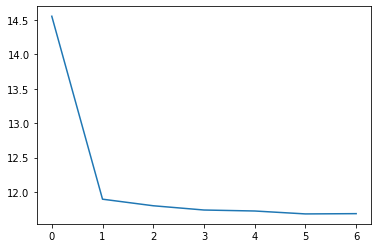

In [66]:
hidden_size = 200
output_size= len(unique([item for sublist in testnpall for item in sublist]))
decoder1 = DecoderRNN(hidden_size,output_size)
plot_losses = trainIters(decoder1, 750, print_every=100, plot_every=100, learning_rate=0.01)

In [67]:
pwd

'/home/mamjad2'

In [812]:
PATH_TO_ORIGINAL_DATA = '/home/mamjad2/trivagodata/'
test = pd.read_csv(PATH_TO_ORIGINAL_DATA + 'test.csv')

#Subset data with not null itemID refrence of item ID
dftest1=test[(test['action_type'] != 'change of sort order') & (test['action_type'] !='filter selection') & (test['action_type'] !='search for destination')& (test['action_type'] !='search for poi') & (test['action_type'] !='clickout item') & (test['reference'].notnull()) & (test['reference']!='unknown')]
#Subset data with null refrence only for Clickouts
dftest2=test[(test['action_type'] == 'clickout item') & (test['reference'].isnull())] 

#Test data
dftest_session=dftest1.append(dftest2, ignore_index=True)
#dftest["sequence"] = np.nan #adds item sequence in the session to the session
# dftest.to_csv("./dftest.csv", sep=',',index=False)


In [813]:
for item in item_meta['item_id']:
    if item not in flat_list_train:
        item2idx[item]=n_items
        idx2item[n_items]=item
        n_items+=1
    else:
        continue

In [814]:
def make_session(dftest, session_id):

    sequence=[]
    tstusr_session= dftest[dftest['session_id'] == session_dic[session_id]]
    tstusr_session=tstusr_session.sort_values('step')
    temp=tstusr_session['reference'] #Note:This sequence of interacted items can have repetetive item even consequetively! 

    if len(temp)==1 and temp.isna().any()==True:
        sequence=[]
        #print('Empty', temp)
        #Sort impressions based on their probabilities

    elif len(list(np.where(tstusr_session['reference'].isna())))==1 and len(temp)-1 in np.where(tstusr_session['reference'].isna()):
        seq=temp[:-1]
        seq=seq.to_numpy()
        sequence=[int(x) for x in seq]
        print('Sequence', len(sequence))
        #DO prdiction for seq

    elif len(list(np.where(tstusr_session['reference'].isna())))>1:
        sequence=temp
        #print('2NaN', temp)

    elif temp.isna().any()==False:
        sequence=temp
        #print('NoNan', temp)

    else:
        #print('ALERT', temp)
        sequence=temp
        
    return sequence

In [815]:

            
        
        #datanp.append([NaNidx if math.isnan(x) else int(x) for x in train])
#print(counter)

#tstnp= sorted(tstnp, key=len, reverse=True)
#pickle.dump(tstnp, open('tstemp.pkle', 'wb'))

#np.savetxt('temp.txt', datanp)
#data=torch.from_numpy(np.array(datanp))

In [816]:
# test['action_type'].unique() #unique values in action_type column

##Subseting the data into the clickouts and null only
df_puretest=test[(test['action_type'] == 'clickout item') & (test['reference'].isnull())] 
impdict=dict(df_puretest['impressions'])
session_dic=dict(df_puretest['session_id'])
dfsubmit=df_puretest.loc[:,['user_id','session_id','timestamp', 'step', 'impressions']]
dfsubmit.columns=['user_id','session_id','timestamp', 'step', 'item_recommendations']

In [817]:
def get_data():
    
    PATH_TO_ORIGINAL_DATA = '/home/mamjad2/trivagodata/'
    train = pd.read_csv(PATH_TO_ORIGINAL_DATA + 'train.csv')
    #train = pd.read_csv('train.csv') #read data
    #train['action_type'].unique() #unique values in action_type column

    ##Subseting the train data into the clickouts only
    dftrain=train[train['action_type'] == 'clickout item'] 

    ##Computing the probability of clicking each item
    freq=dftrain['reference'].value_counts() #Counts the frequencies

    prob=freq/len(dftrain['reference']) #compute the probablitie
    probdic=dict(prob) #Store items as keys in the dict

    test = pd.read_csv(PATH_TO_ORIGINAL_DATA + 'test.csv')
    #test.head(5) #display first 5 rows

    # test['action_type'].unique() #unique values in action_type column

    ##Subseting the data into the clickouts and null only
    dftestsub=test[(test['action_type'] == 'clickout item') & (test['reference'].isnull())] 
    impdict=dict(dftestsub['impressions'])
    dfsubmit=dftestsub.loc[:,['user_id','session_id','timestamp', 'step', 'impressions']]
    dfsubmit.columns=['user_id','session_id','timestamp', 'step', 'item_recommendations']

    return probdic,impdict,dfsubmit

In [818]:
def Scorenew(impressions_string, probdic):
    
    implist= impressions_string.split("|")
    probimp=[]
    for j in implist:
        if j in probdic:
            probimp.append(probdic[j])
        else:
            probimp.append(0)


    temp = sorted(zip(probimp,implist), reverse = True)

    return ' '.join([x for _,x in temp])

In [819]:
def evaluate(decoder, sequence, impressions, n_items):
    with torch.no_grad():
        input_tensor = tensor4seq(sequence)[2]
        input_length = input_tensor.size()[0]
        decoder_hidden = decoder.initHidden()

        #encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            decoder_output, decoder_hidden = decoder(input_tensor[ei],
                                                     decoder_hidden)
            #decoded_words = []
            #decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = input_tensor[ei].squeeze()
            
        topv, topi = decoder_output.data.topk(n_items)
        topi = topi.tolist()
        impindx= seq2indx([int(x) for x in impressions.split('|')])
        
        sorted_imp= [x for x in topi if x in impindx]
        

        return ' '.join([str(x) for x in sorted_imp])

In [820]:
# decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
# criterion = nn.NLLLoss()

#probdic,impdict,dfsubmit = get_data()
#pickle.dump([probdic,impdict,dfsubmit],open('processed.pkl','wb'))

[probdic,impdict,dfsubmit] = pickle.load(open('processed.pkl','rb'))

count=0
for x in session_dic:
    start = time.time()
    seq=make_session(dftest_session, x)
    print(seq)
    if len(seq)==0:
        dfsubmit['item_recommendations'][x] = Scorenew(impdict[x],probdic)
    
    else:
        imp=impdict[x]
        dfsubmit['item_recommendations'][x] = evaluate(decoder1, seq, imp, n_items)
        
    count += 1    
    if count % 1000 == 0:
        dfsubmit.to_csv("./submit.csv", sep=',',index=False)
        end = time.time()
        print(count)
        print(end-start)
        break

Sequence 2
[2059240, 2059240]


RuntimeError: index out of range at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:193